In [7]:
import sys
sys.path.append('../lib/')

from sandpipline import (get_all_rate_file_at_path,  
                         select_dither_band,  
                         select_dither_type,
                         from_XY_point_cloud_to_function, 
                         create_continuous_alphaMap,
                         from_alphabeta_point_cloud_to_function,
                         sort_dither_by_position,
                         shoow_maps,
                         )

import time as t
import numpy as np
import pickle
from os.path import isdir
from os import mkdir

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
plt.close("all")
plt.rcParams['text.usetex'] = True

cdpDir = '../DATA/mrs_distortion_fits/'
version = "flt7"

In [8]:
# %% Read files

# --- Process refs, or read it if already processed
have_a_save = True
datadir = "../DATA/REFS2/"
ref_pickel_name = "../DATA/REFS2/rate_ref2"

save_model = "../DATA/NON/"
if not isdir(save_model):
    mkdir(save_model)
    
if have_a_save:

    with open(ref_pickel_name, 'rb') as handle:
        saved_rate_infos = pickle.load(handle)
    cube_frame, centers_list, sigmas_list, dith_type, numdi_list, name_list, bandCHAN = saved_rate_infos

else:
    cube_frame, centers_list, sigmas_list, dith_type, numdi_list, name_list, bandCHAN = get_all_rate_file_at_path(datadir,
                                                                                                                  cdpDir,
                                                                                                                  ref_pickel_name,
                                                                                                                  map3to4=True,
                                                                                                                  v=version,
                                                                                                                  suff="_rate")

Procees B12NEGATIVE1
9


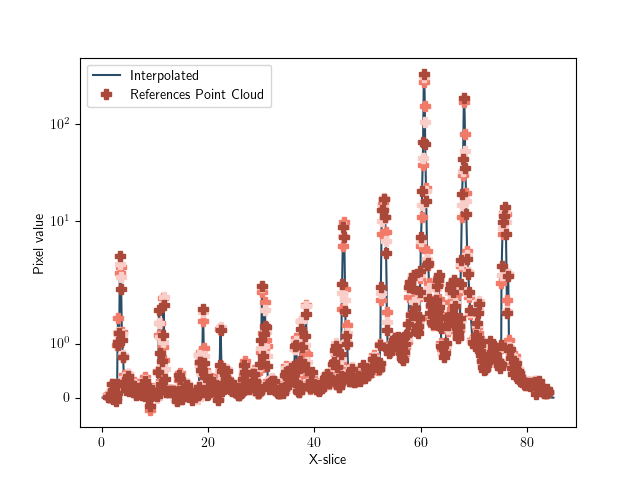

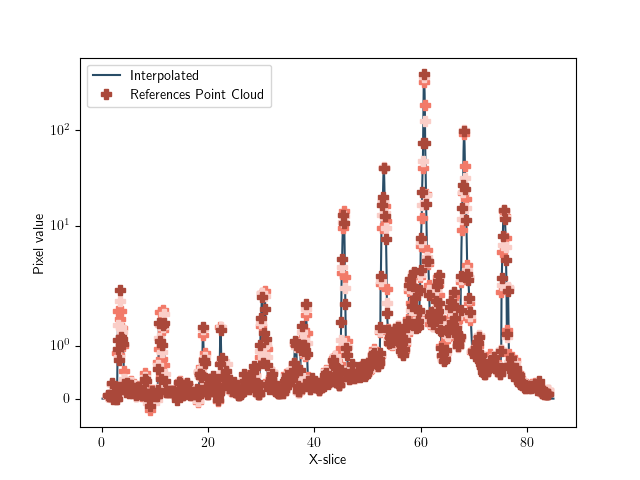

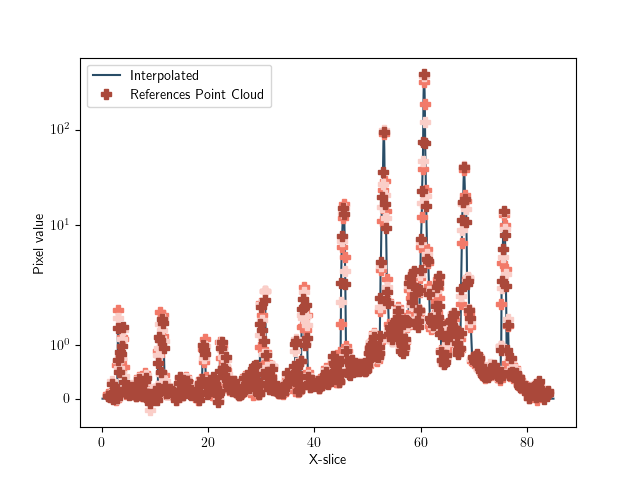

In [9]:
# Create the models
enuum_types = ['NEGATIVE1', 'NEGATIVE2', 'NEGATIVE3', 'NEGATIVE4',
               'POSITIVE1', 'POSITIVE2', 'POSITIVE3', 'POSITIVE4']

for band_chan_K in ["B12"]:#, "B12", "C12","A34", "B34", "C34"]:
    for type_k in enuum_types:

        print("Procees "+band_chan_K+type_k)

        # -- Select the dither from the correct band.
        cube_frame_band_i, centers_band_i, numdi_band_type_i, dith_type_band_i, name_list_band_i = select_dither_band(band_chan_K,
                                                                                                                      cube_frame,
                                                                                                                      centers_list,
                                                                                                                      dith_type,
                                                                                                                      numdi_list,
                                                                                                                      bandCHAN,
                                                                                                                      name_list=name_list)
        if cube_frame_band_i.size == 0:
            continue  # If there is no rate matching band, we skip from here to the next band

        # -- Select the dither from the right type.
        cube_frame_type_i, centers_type_i, numdi_list_type_i, name_list_type_i = select_dither_type(type_k,
                                                                                                    cube_frame_band_i,
                                                                                                    centers_band_i,
                                                                                                    dith_type_band_i,
                                                                                                    numdi_band_type_i,
                                                                                                    name_list_band_i)
        if cube_frame_type_i.size == 0:
            continue  # If there is no rate matching type, we skip from here to the next type

        id_ref = [name_list.index(target) for target in name_list_type_i]
        print(cube_frame_type_i.shape[0])
        if "4" in band_chan_K:
            continue
            # list_function_L, list_function_R = from_alphabeta_point_cloud_to_function(
            #     cube_frame_type_i, centers_type_i, band_chan_K, cdpDir, version, show="Model "+band_chan_K+type_k)
            # models_dict = {"list_function_L": list_function_L,
            #                "list_function_R": list_function_R}
                        
            # with open(save_model+band_chan_K+"_"+type_k, 'wb') as handle:
            #     pickle.dump((models_dict), handle)
        else:            
            X_coor = create_continuous_alphaMap(
                band_chan_K, cdpDir, v=version, show=False)
            
            
            if (cube_frame_type_i.shape[0])==1 :
                img_model_k, function_L_k = from_XY_point_cloud_to_function(X_coor, cube_frame_type_i,centers_type_i, which_side="l",
                                                                        filter_noise=False, show="Model L row"+"_"+band_chan_K+type_k)
                
                img_model_k, function_R_k = from_XY_point_cloud_to_function(X_coor, cube_frame_type_i,centers_type_i, which_side="r",
                                                                            filter_noise=False, show="Model R row"+"_"+band_chan_K+type_k)
                
                rows_dict = { "rows_l":{"0":{"function":function_L_k, "centroids":centers_type_i[0][1], "name":numdi_list[0]}},
                              "rows_r":{"0":{"function":function_R_k, "centroids":centers_type_i[0][1], "name":numdi_list[0]}}}
            
            else : 
                
                rows_dict = sort_dither_by_position(
                    cube_frame_type_i, centers_type_i, numdi_list)

                for kk, row_k in enumerate(rows_dict["rows_l"].values()):
                    img_model_k, function_L_k = from_XY_point_cloud_to_function(X_coor, row_k["cubes"], row_k["centroids"], which_side="l",
                                                                            filter_noise=False, show="Model L row"+str(kk)+"_"+band_chan_K+type_k)
                    row_k["function"] = function_L_k
                    del row_k["cubes"]
                break
                for kk, row_k in enumerate(rows_dict["rows_r"].values()):
                    img_model_k, function_R_k = from_XY_point_cloud_to_function(X_coor, row_k["cubes"], row_k["centroids"], which_side="r",
                                                                            filter_noise=False, show="Model R row"+str(kk)+"_"+band_chan_K+type_k)
                    row_k["function"] = function_R_k
                    del row_k["cubes"]

            break
            with open(save_model+band_chan_K+"_"+type_k, 'wb') as handle:
                pickle.dump((rows_dict), handle)